# Team Members:
# 1. Nishchal Marur Nanjunda Swamy - 121331434
# 2. Satwika Konda - 121331717

# Portfolio Analysis Made Easy: Automating Ticker Parsing and Portfolio Insights

## Introduction

In the fast-paced world of stock trading and investment, information is key. Often, stock data is shared in diverse formats such as screenshots from trading apps, spreadsheets, or plain text files. Manually processing this data to extract ticker symbols and gather actionable insights can be both time-consuming and error-prone.

This project aims to bridge the gap between raw, unstructured data and meaningful financial insights by automating the entire process. Using advanced techniques in Optical Character Recognition (OCR), Natural Language Processing (NLP), and Machine Learning (ML), we build a pipeline that:

*   Extracts stock tickers from various input formats, including screenshots.
*   Validates the extracted tickers against real-world data.
*   Fetches historical and real-time market data.
*   Applies ML models to analyze trends and project future performance.
*   Give meaningful and insightful visualizations and recommendations on their portfolio.



Through this tutorial, you’ll learn how to implement a complete data science pipeline, from data curation and parsing to analysis and insightful visualizations. Whether you’re an investor, a data enthusiast, or a curious learner, this project offers a practical guide to combining data science with finance.

# Part 1: Parsing Stock Tickers from Images Using OCR

In this section, we demonstrate how to process stock ticker screenshots using Optical Character Recognition (OCR). Screenshots are a common way for users to share stock information, and automating the extraction of ticker symbols saves time and effort.


In [154]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 26.3 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [151]:
# Some common imports
import os
import cv2
import json
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import requests
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import networkx as nx
import plotly.express as px

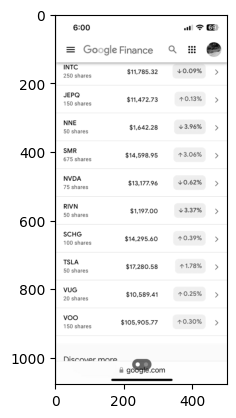

In [152]:
# Path to the image
image_path = '/content/drive/My Drive/Stock Dashboard/ticker_images/img_0.png'

# Open and display the image
img = cv2.imread(image_path)

# Converting to grayscale for better OCR results
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')
plt.show()

In [155]:
import easyocr
import torch

if torch.cuda.is_available():
    print("GPU is available!")
else:
    print("GPU is not available.")

reader = easyocr.Reader(['en'], gpu=True)
text = reader.readtext(gray_image, detail=0)
text = ' '.join(text)
print("Extracted Text:", text)

GPU is available!
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteExtracted Text: 6:00 69 Google Finance Q INTC $11,785.32 +0.09% 250 shares JEPQ $11,472.73 ^0.13% 150 shares NNE $1,642.28 +3.96% 50 shares SMR S14,598.95 ^3.06% 675 shares NVDA S13,177.96 0.62% 75 shares RIVN $1,197.00 13.37% 50 shares SCHG S14,295.60 ^0.39% 100 shares TSLA $17,280.58 11.78% 50 shares VUG $10,589.41 ^0.25% 20 shares VOO $105,905.77 ^0.30% 150 shares Diccouer mora google.com


In [156]:
# Extracting potential tickers using regex
def extract_potential_tickers(text):
    tickers = re.findall(r'\b[A-Z]{1,5}(?:\.[A-Z]{1,3})?\b', text)
    return tickers

potential_tickers = extract_potential_tickers(text)
cleaned_tickers = [ticker.strip("~‘,.") for ticker in potential_tickers if len(ticker) > 1]
print("Cleaned Potential Tickers:", cleaned_tickers)

Cleaned Potential Tickers: ['INTC', 'JEPQ', 'NNE', 'SMR', 'NVDA', 'RIVN', 'SCHG', 'TSLA', 'VUG', 'VOO']


### Ticker Validation
For validating the ticker names, we have downloaded the most recent dataset containing 3361 stocks present on the NASDAQ, with daily information ranging from 1962-01-02 till 2024-08-27. Source: https://www.kaggle.com/datasets/svaningelgem/nasdaq-daily-stock-prices

We have a db text file for fast lookup which we load in a set and also update our db file with new tickers not present in our file and which are valid.

We check if the missing tickers are valid or not by using API calls and also dynamically store the live market data of those stocks for further usage.

In [158]:
import requests

def web_validation(ticker_name):
  # URL with ticker_name to check
  url = "https://in.tradingview.com/symbols/"+ticker_name

  response = requests.get(url)

  # Check if the response contains the page is not what we are looking for
  if "This isn't the page you're looking for" in response.text:
      print("The page is not found")
      return False
  else:
      print("The page is accessible")
      return True

In [159]:
tickers_db_path = '/content/drive/My Drive/Stock Dashboard/ticker_db.txt'

# Loading strings into a set for O(1) Lookup
tickers = {}

with open(tickers_db_path, 'r') as file:
    tickers = set(file.read().splitlines())

# Check if the ticker is in the set and update if found
def check_and_update(ticker_name):
    if ticker_name not in tickers:
      valid_flag = web_validation(ticker_name)

      if valid_flag:
        tickers.add(ticker_name)
        with open(tickers_db_path, 'w') as file:
            file.write('\n'.join(tickers))
        print(f"Found through web validation and added: {ticker_name}")
      else:
        print(f'{ticker_name} not found in the list and also through web validation')
        return False
    else:
      print(f'{ticker_name} found in the list')
    return True

final_ticker_list = []
for ticker_name in cleaned_tickers:
  if check_and_update(ticker_name):
    final_ticker_list.append(ticker_name)

INTC found in the list
JEPQ found in the list
NNE found in the list
SMR found in the list
NVDA found in the list
RIVN found in the list
SCHG found in the list
TSLA found in the list
VUG found in the list
VOO found in the list


In [160]:
print('Final ticker list:', final_ticker_list)

Final ticker list: ['INTC', 'JEPQ', 'NNE', 'SMR', 'NVDA', 'RIVN', 'SCHG', 'TSLA', 'VUG', 'VOO']


## Loading Input data from Stock Reports

Stock Reports can come in various forms. We have taken the four most common forms and extracted the necessary data from those input sources.

The four formats that the input data is available in are:
* .txt
* .xlsx
* .csv
* .png / .jpg

The functions given below are designed to extract stock ticker names from any document that is of one of the aforementioned formats.

In [161]:
def load_ticker_file(ticker_file):
    try:
        with open(ticker_file, 'r') as file:
            tickers = {line.strip() for line in file}
        return tickers
    except FileNotFoundError:
        print(f"Error: Ticker file '{ticker_file}' not found.")
        return set()

def detect_tickers_in_text(input_file, tickers):
    detected_tickers = set()

    try:
        with open(input_file, 'r') as file:
            for line in file:
                # Matching words in all caps surrounded by spaces
                potential_tickers = re.findall(r'\s([A-Z]{1,5})\s', line)

                # Checking first and last words in the line (if they exist and are in all caps)
                words = line.split()
                first_word = words[0]
                last_word = words[-1]
                if words:
                    # Addingg first word if it's all caps
                    if re.fullmatch(r'[A-Z]{1,5}', first_word):
                        potential_tickers.append(first_word)
                    # Adding last word if it's all caps
                    if len(words) > 1 and re.fullmatch(r'[A-Z]{1,5}', last_word):
                        potential_tickers.append(last_word)

                # Checking existence in the ticker set
                detected_tickers.update({ticker for ticker in potential_tickers if ticker in tickers})
        return detected_tickers
    except FileNotFoundError:
        print(f"Error: Input file '{input_file}' not found.")
        return set()

def detect_tickers_in_xlsx(input_file, tickers):
    detected_tickers = set()
    try:
        # Loading Excel file into a DataFrame
        data = pd.read_excel(input_file, header=None)
        all_text = []

        # Flattening DataFrame into a single list of strings
        for row in data.itertuples(index=False):
            for cell in row:
                # Checking if the cell contains text and appending it if it does
                if isinstance(cell, str):
                    all_text.append(cell)

        # Combining all text into a single space-separated string
        combined_text = " ".join(all_text)

        # Matching all uppercase words with spaces and add first/last word
        potential_tickers = re.findall(r'\b[A-Z]{1,5}\b', combined_text)
        detected_tickers.update({ticker for ticker in potential_tickers if ticker in tickers})

        # Checking the first and last words in the file
        if all_text:
            first_word = all_text[0].strip().split()[0]
            last_word = all_text[-1].strip().split()[-1]
            if first_word.isupper() and first_word in tickers:
                detected_tickers.add(first_word)
            if last_word.isupper() and last_word in tickers:
                detected_tickers.add(last_word)

        return detected_tickers
    except FileNotFoundError:
        print(f"Error: XLSX file '{input_file}' not found.")
        return set()
    except Exception as e:
        print(f"Error processing XLSX file: {e}")
        return set()

def detect_tickers_in_csv(input_file, tickers):
    detected_tickers = set()
    try:
        # Loading CSV file into a DataFrame
        data = pd.read_csv(input_file, header=None)
        all_text = []

        # Flattening DataFrame into a single list of strings
        for row in data.itertuples(index=False):
            for cell in row:
                # Checking if the cell contains text and appending it if it does
                if isinstance(cell, str):
                    all_text.append(cell)

        # Combining all text into a single space-separated string
        combined_text = " ".join(all_text)

        # Matching all uppercase words with spaces and add first/last word
        potential_tickers = re.findall(r'\b[A-Z]{1,5}\b', combined_text)
        detected_tickers.update({ticker for ticker in potential_tickers if ticker in tickers})

        # Checking the first and last words in the file
        if all_text:
            first_word = all_text[0].strip().split()[0]
            last_word = all_text[-1].strip().split()[-1]
            if first_word.isupper() and first_word in tickers:
                detected_tickers.add(first_word)
            if last_word.isupper() and last_word in tickers:
                detected_tickers.add(last_word)

        return detected_tickers
    except FileNotFoundError:
        print(f"Error: CSV file '{input_file}' not found.")
        return set()
    except Exception as e:
        print(f"Error processing CSV file: {e}")
        return set()

In [163]:
ticker_file_path = "/content/drive/MyDrive/MSML602_DS_FinalProject/ticker_db.txt"
tickers = load_ticker_file(ticker_file_path)

Using the function created above to extract stock ticker names from .txt document.

In [164]:
text_file_path = "/content/drive/MyDrive/MSML602_DS_FinalProject/StockReport.txt"
detected_tickers = detect_tickers_in_text(text_file_path, tickers)

if detected_tickers:
    print("Detected tickers:", ", ".join(sorted(detected_tickers)))
else:
    print("No tickers detected in the input file.")

Detected tickers: AAPL, COCO, TSLA, ZWS


Using the function created above to extract stock ticker names from .xlsx document.

In [165]:
xlsx_file_path = "/content/drive/MyDrive/MSML602_DS_FinalProject/StockReport.xlsx"
detected_tickers = detect_tickers_in_xlsx(xlsx_file_path, tickers)

if detected_tickers:
    print("Detected tickers:", ", ".join(sorted(detected_tickers)))
else:
    print("No tickers detected in the input file.")

Detected tickers: AAPL, COCO, TSLA, ZWS


Using the function created above to extract stock ticker names from .csv document.

In [166]:
csv_file_path = "/content/drive/MyDrive/MSML602_DS_FinalProject/StockReport.csv"
detected_tickers = detect_tickers_in_csv(csv_file_path, tickers)

if detected_tickers:
    print("Detected tickers:", ", ".join(sorted(detected_tickers)))
else:
    print("No tickers detected in the input file.")

Detected tickers: AAPL, COCO, TSLA, ZWS


In [168]:
input_tickers = sorted(list(detected_tickers))
input_tickers

['AAPL', 'COCO', 'TSLA', 'ZWS']

# Part 2: Cluster-Based Stock Portfolio Diversification


### Data Collection

Since a dataset is not readily available (given that we will need the most recent data to assess how a stock is doing at present), we will be scraping the live data everytime need to perform this task.

In the kernel below, we defined functions that will essentially be extracting various stock ticker names from Stock Exchanges like Nasdaq, NYSE and Amex. We employed [requests](https://pypi.org/project/requests/) library to get the data.

In [169]:
def fetch_tickers_from_nasdaq():
    url = "https://api.nasdaq.com/api/screener/stocks?exchange=nasdaq&download=true"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    data = response.json()

    # Extracting tickers
    tickers = [row["symbol"] for row in data["data"]["rows"]]
    return tickers

def fetch_tickers_from_nyse():
    url = "https://api.nasdaq.com/api/screener/stocks?exchange=nyse&download=true"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    data = response.json()

    # Extracting tickers
    tickers = [row["symbol"] for row in data["data"]["rows"]]
    return tickers

def fetch_tickers_from_amex():
    url = "https://api.nasdaq.com/api/screener/stocks?exchange=amex&download=true"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    data = response.json()

    # Extracting tickers
    tickers = [row["symbol"] for row in data["data"]["rows"]]
    return tickers

def fetch_all_tickers():
    print("Fetching NASDAQ tickers...")
    nasdaq_tickers = fetch_tickers_from_nasdaq()

    print("Fetching NYSE tickers...")
    nyse_tickers = fetch_tickers_from_nyse()

    print("Fetching AMEX tickers...")
    amex_tickers = fetch_tickers_from_amex()

    # Combining all tickers
    all_tickers = list(set(nasdaq_tickers + nyse_tickers + amex_tickers))
    return all_tickers

Using the functions that we defined above, we extracted all stock ticker names from the stock exchange websites. All of these are then saved to a .csv file for future references.

In [170]:
print("Fetching all stock tickers...")
all_tickers = fetch_all_tickers()
all_tickers = sorted(all_tickers)
print(f"Total number of Tickers Found: {len(all_tickers)}")

# Saving to a CSV file for future use
pd.DataFrame({"Ticker": all_tickers}).to_csv("all_tickers.csv", index=False)
print("Tickers saved to all_tickers.csv")

Fetching all stock tickers...
Fetching NASDAQ tickers...
Fetching NYSE tickers...
Fetching AMEX tickers...
Total number of Tickers Found: 6993
Tickers saved to all_tickers.csv


Now, we need the stock data features of all the ticker names that we have. So we created the function below where we use [yfinance](https://pypi.org/project/yfinance/) (an open-source python library that uses Yahoo's public APIs) to extract the necessary features, historical price data in this case, of each ticker.

In [172]:
def fetch_financial_data_yfinance(tickers):
    financial_data = []
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)

            # Fetching historical price data
            hist = stock.history(period="6mo")  # Last 3 months of data
            avg_price = hist['Close'].mean()
            volatility = hist['Close'].std()
            volume = hist['Volume'].mean()

            # Appending metrics to financial_data
            financial_data.append({
                'Ticker': ticker,
                'AvgPrice': avg_price,
                'Volatility': volatility,
                'Volume': volume
            })

            if avg_price != 'nan':
                pass

        except Exception as e:
            pass
    return pd.DataFrame(financial_data)

Using the function created above, we extract the historical features of all the tickers extracted through Data Scraping. The data of a total of 6992 tickers has been collected.

In [176]:
# Fetching financial data for all tickers in tickers_file
print("Fetching financial data for all tickers...")
financial_data = fetch_financial_data_yfinance(all_tickers)
print("Financial Data:\n", financial_data)

Fetching financial data for all tickers...

    Financial Data:
       Ticker    AvgPrice  Volatility        Volume
0     Ticker         NaN         NaN           NaN
1          A  136.628404    5.353285  1.787548e+06
2         AA   37.804715    5.097040  5.445425e+06
3       AACG    0.796299    0.171042  4.042451e+04
4       AACT   10.796047    0.084003  2.017648e+05
...      ...         ...         ...           ...
6988    ZVRA    7.347205    1.420258  8.226050e+05
6989    ZVSA    2.652080    1.121720  6.963975e+05
6990     ZWS   34.242520    3.776245  1.240490e+06
6991    ZYME   11.989528    2.166634  6.041746e+05
6992    ZYXI    8.397795    0.676874  1.216620e+05

[6993 rows x 4 columns]



### Data Cleaning

The data collected has a lot of null values. This happened becaue Yahoo Finance implements rate limits to prevent overloading their servers. And since we made too many requests in a short period of time, the API returned incomplete or missing data for some tickers. To ensure better learning of the model, this missing data needs to be handled.

In [ ]:
financial_data

,Ticker,AvgPrice,Volatility,Volume
0,Ticker,NaN,NaN,NaN
1,A,136.628404,5.353285,1.787548e+06
2,AA,37.804715,5.097040,5.445425e+06
3,AACG,0.796299,0.171042,4.042451e+04
4,AACT,10.796047,0.084003,2.017648e+05
...,...,...,...,...
6988,ZVRA,7.347205,1.420258,8.226050e+05
6989,ZVSA,2.652080,1.121720,6.963975e+05
6990,ZWS,34.242520,3.776245,1.240490e+06
6991,ZYME,11.989528,2.166634,6.041746e+05


In [ ]:
len(financial_data)

6993

To handle the missing data, we removed all records that were missing data.

In [179]:
financial_data = financial_data[~financial_data.apply(lambda row: row.astype(str).str.contains('nan')).any(axis=1)]
financial_data

,Ticker,AvgPrice,Volatility,Volume
0,A,136.628404,5.353285,1.787548e+06
1,AA,37.804715,5.097040,5.445425e+06
2,AACG,0.796299,0.171042,4.042451e+04
3,AACT,10.796047,0.084003,2.017648e+05
4,AADI,1.840591,0.316452,2.062802e+05
...,...,...,...,...
4997,ZVRA,7.347205,1.420258,8.226050e+05
4998,ZVSA,2.652080,1.121720,6.963975e+05
4999,ZWS,34.242520,3.776245,1.240490e+06
5000,ZYME,11.989528,2.166634,6.041746e+05


Almost 2,000 rows were removed as a result.

In [180]:
len(financial_data)

5002

In case any of these operations disrupted the flow of the index, we reset the index to avoid any issues further.

In [181]:
financial_data = financial_data.reset_index(drop=True)
financial_data

,Ticker,AvgPrice,Volatility,Volume
0,A,136.628404,5.353285,1.787548e+06
1,AA,37.804715,5.097040,5.445425e+06
2,AACG,0.796299,0.171042,4.042451e+04
3,AACT,10.796047,0.084003,2.017648e+05
4,AADI,1.840591,0.316452,2.062802e+05
...,...,...,...,...
4997,ZVRA,7.347205,1.420258,8.226050e+05
4998,ZVSA,2.652080,1.121720,6.963975e+05
4999,ZWS,34.242520,3.776245,1.240490e+06
5000,ZYME,11.989528,2.166634,6.041746e+05


We saved the financial data that we've collected so that it can be useful for future references.

In [182]:
financial_data.to_csv('/content/drive/MyDrive/MSML602_DS_FinalProject/financial_data_v1.csv', index=False)

Moving on, as we will be using [K-Means clustering](https://www.ibm.com/think/topics/k-means-clustering) and [Principal Component Analysis (PCA)](https://www.ibm.com/topics/principal-component-analysis) further down the road, Normalization of data is necessary because both methods are sensitive to the scale of the data.

K-Means clustering relies on distance metrics (e.g., [Euclidean distance](https://hlab.stanford.edu/brian/euclidean_distance_in.html), [Manhattan distance](https://cp-algorithms.com/geometry/manhattan-distance.html), [Cosine distance](https://medium.com/@milana.shxanukova15/cosine-distance-and-cosine-similarity-a5da0e4d9ded)) to group similar data points, so it is very easy for features with larger scales to dominate the clustering process. Similarly, PCA aims to reduce dimensionality by identifying the principal components, which can be influenced by features with larger variances. Normalizing ensures that all features contribute equally to the models' learning.

In [183]:
# Feature columns to scale
feature_cols = ['AvgPrice', 'Volatility', 'Volume']

# Scaling Input Ticker data
scaler = StandardScaler()
scaled_features_financial_data = scaler.fit_transform(financial_data[feature_cols])
scaled_financial_data = financial_data.copy()
scaled_financial_data[feature_cols] = scaled_features_financial_data

print(scaled_financial_data)

     Ticker  AvgPrice  Volatility    Volume
0         A  0.799533    0.092723  0.096342
1        AA -0.048665    0.070679  0.979402
2      AACG -0.366306   -0.353092 -0.325438
3      AACT -0.280478   -0.360580 -0.286488
4      AADI -0.357342   -0.340583 -0.285398
...     ...       ...         ...       ...
4997   ZVRA -0.310080   -0.245625 -0.136609
4998   ZVSA -0.350377   -0.271307 -0.167077
4999    ZWS -0.079239   -0.042945 -0.035726
5000   ZYME -0.270235   -0.181416 -0.189341
5001   ZYXI -0.301062   -0.309576 -0.305826

[5002 rows x 4 columns]


In [184]:
# Extracting tickers from input files
input_ticker_data = fetch_financial_data_yfinance(input_tickers)
input_ticker_data

,Ticker,AvgPrice,Volatility,Volume
0,AAPL,226.014961,8.667177,5.231187e+07
1,COCO,29.278307,3.874990,5.369465e+05
2,TSLA,253.724174,57.829142,9.269452e+07
3,ZWS,34.242520,3.776245,1.243263e+06


Just as we scaled the financial data, we scaled the input data too.

In [185]:
# Feature columns to scale
feature_cols = ['AvgPrice', 'Volatility', 'Volume']

# Scaling Input Ticker data
scaler = StandardScaler()
scaled_features_input_ticker_data = scaler.fit_transform(input_ticker_data[feature_cols])
scaled_input_ticker_data = input_ticker_data.copy()
scaled_input_ticker_data[feature_cols] = scaled_features_input_ticker_data

print(scaled_input_ticker_data)

  Ticker  AvgPrice  Volatility    Volume
0   AAPL  0.862914   -0.433426  0.405076
1   COCO -1.019202   -0.643874 -0.938022
2   TSLA  1.127999    1.725512  1.452646
3    ZWS -0.971711   -0.648211 -0.919700


### Model Building and Visualizations

In this part of the project, we aim to find out the top 5-10 stocks that are most similar to the stocks whose tickers have been extracted earlier. To achieve this, we employed an unsupervised learning algorithm known as K-Means Clustering.

Before performing K-Means Clustering, we want to know the optimal 'n' (number of clusters the algorithm needs to create). The [elbow method](https://medium.com/@zalarushirajsinh07/the-elbow-method-finding-the-optimal-number-of-clusters-d297f5aeb189) is a popular technique used to determine the optimal number of clusters for K-Means clustering. It helps one decide how many clusters provide the best trade-off between model complexity (number of clusters) and the accuracy of the fit.

In [186]:
def determine_optimal_clusters(financial_data, scaled_features, max_clusters=15):
    wcss = []  # List to store within-cluster sum of squares for each k

    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_features)
        wcss.append(kmeans.inertia_)

    # Plotting the Elbow Method
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS')
    plt.title('Elbow Method for Optimal Clusters')
    plt.show()

    # Finding the optimal number of clusters
    optimal_k = np.diff(np.diff(wcss)).argmin() + 2  # Second derivative "elbow point"
    print(f"Optimal number of clusters: {optimal_k}")
    return optimal_k

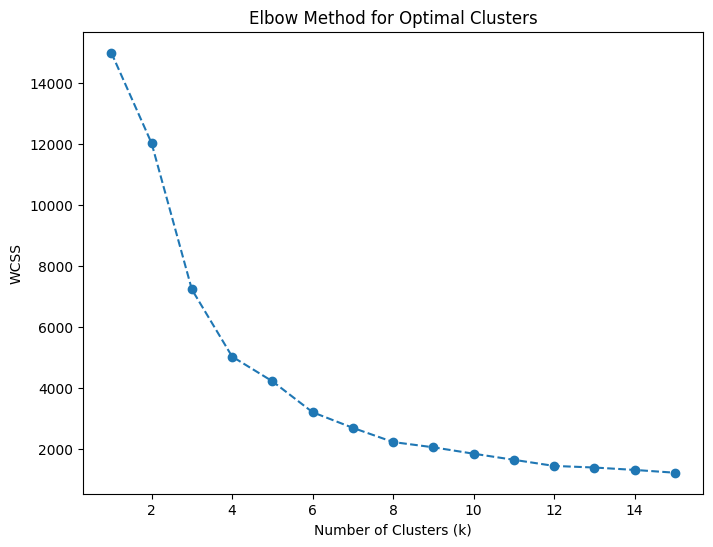

Optimal number of clusters: 2


In [187]:
optimal_num_of_clusters = determine_optimal_clusters(scaled_financial_data, scaled_features_financial_data)

The elbow method says 2 is the optimal number of clusters to use on this data. While the elbow method is a common technique to estimate the optimal number of clusters, we feel it is not providing the best solution to our use-case based on the nature of the data being dealt withh here and especially, the objectives of our analysis.

Since we are dealing with a large number of stocks and want to explore more diversity, we chose to perform clustering with a higher cluster number (n=6).

We created a function that performs K-Means Clustering and clustered the financial data using it. Each record of the financial data has been assigned to one of the six clusters. The clusters have been visualized as well.

In [188]:
def perform_clustering(financial_data, scaled_features, n_clusters):
    # Applying K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    financial_data['Cluster'] = kmeans.fit_predict(scaled_features_financial_data)

    return financial_data, scaled_features, kmeans

In [189]:
# Performing clustering
print("\nPerforming clustering...")
clustered_data, scaled_features_of_financial_data, kmeans = perform_clustering(scaled_financial_data, scaled_features_financial_data, 6)
print("Clustered Data:\n", clustered_data)


Performing clustering...
Clustered Data:
      Ticker  AvgPrice  Volatility    Volume  Cluster
0         A  0.799533    0.092723  0.096342        0
1        AA -0.048665    0.070679  0.979402        4
2      AACG -0.366306   -0.353092 -0.325438        0
3      AACT -0.280478   -0.360580 -0.286488        0
4      AADI -0.357342   -0.340583 -0.285398        0
...     ...       ...         ...       ...      ...
4997   ZVRA -0.310080   -0.245625 -0.136609        0
4998   ZVSA -0.350377   -0.271307 -0.167077        0
4999    ZWS -0.079239   -0.042945 -0.035726        0
5000   ZYME -0.270235   -0.181416 -0.189341        0
5001   ZYXI -0.301062   -0.309576 -0.305826        0

[5002 rows x 5 columns]


In [192]:
def visualize_clusters(financial_data):
    # Extracting features and cluster labels
    feature_cols = ['AvgPrice', 'Volatility', 'Volume']
    features = financial_data[feature_cols]
    labels = financial_data['Cluster']

    # Reducing dimensions with PCA
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features)

    # Plotting the clusters
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis', s=100)
    plt.title("Stock Clusters")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(label='Cluster')
    plt.show()

    fig = px.scatter(clustered_data, reduced_features[:, 0], y=reduced_features[:, 1], color='Cluster', hover_data=['Ticker'])
    fig.show()


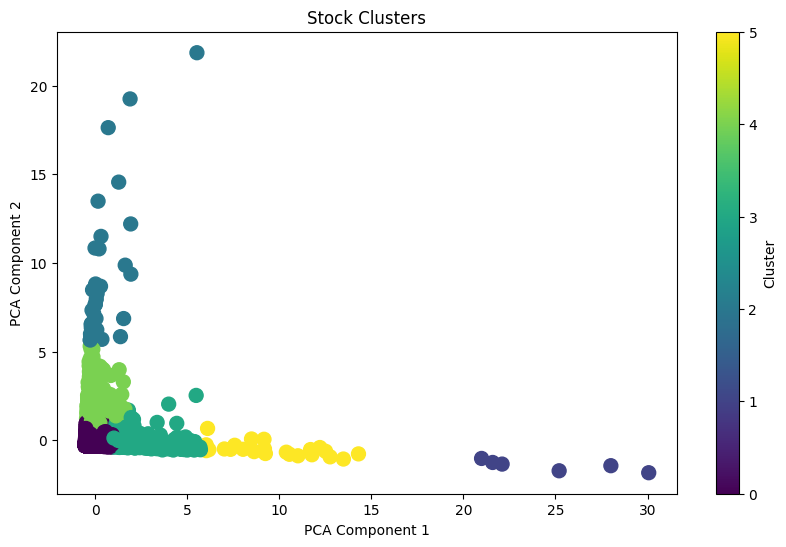

In [193]:
visualize_clusters(clustered_data)

This graph compares the distribution of features like average price, volatility, and volume across different clusters that have been computed. This can help identify which clusters are characterized by high/low values in certain metrics.

In [194]:
fig = px.box(clustered_data, x='Cluster', y='AvgPrice', color='Cluster', title='Stock Distribution by Cluster')
fig.show()

Now, we want to find the the 5 most similar stocks to the input stock tickers from the same cluster (if a user wants to add more similar stocks to their portfolio) and from different clusters (if they want to diversify their portfolio).

In [195]:
def find_most_similar_stocks(financial_data, input_ticker_data, top_n=5):
    feature_cols = ['AvgPrice', 'Volatility', 'Volume']
    scaler = StandardScaler()

    # Normalizing the combined financial data
    combined_data = pd.concat([financial_data[feature_cols], input_ticker_data[feature_cols]])
    combined_scaled_features = scaler.fit_transform(combined_data)
    updated_scaled_features = combined_scaled_features[:len(financial_data)]  # Update for financial data only

    similar_stocks_dict = {}

    for _, row in input_ticker_data.iterrows():
        ticker = row['Ticker']

        # If ticker not found in financial data, adding it
        if ticker not in financial_data['Ticker'].values:
            # print(f"Adding new ticker {ticker} to financial data.")
            financial_data = pd.concat([financial_data, pd.DataFrame([row])], ignore_index=True)
            updated_scaled_features = scaler.fit_transform(financial_data[feature_cols])  # Update scaling

        # Finding the ticker row
        ticker_row = financial_data[financial_data['Ticker'] == ticker]
        ticker_index = ticker_row.index[0]
        ticker_cluster = ticker_row['Cluster'].iloc[0]

        # Filtering all stocks in the same cluster
        cluster_stocks = financial_data[financial_data['Cluster'] == ticker_cluster]
        cluster_indices = cluster_stocks.index
        cluster_features = updated_scaled_features[cluster_indices]
        target_features = updated_scaled_features[ticker_index]

        # Computing distances to all stocks in the cluster
        distances = cdist([target_features], cluster_features, metric='cosine').flatten()
        cluster_stocks = cluster_stocks.assign(Distance=distances)

        # Excluding the target ticker itself and sort by distance
        cluster_stocks = cluster_stocks[cluster_stocks['Ticker'] != ticker]
        top_similar = cluster_stocks.sort_values(by='Distance').head(top_n)['Ticker'].tolist()

        similar_stocks_dict[ticker] = top_similar

    return similar_stocks_dict


In [196]:
similar_stock_data = find_most_similar_stocks(scaled_financial_data, scaled_input_ticker_data)
print("The five most similar stocks to each of the input stocks are as follows:\n")
print(similar_stock_data)

The five most similar stocks to each of the input stocks are as follows:

{'AAPL': ['AMD', 'AMZN', 'AVGO', 'GOOGL', 'SMCI'], 'COCO': ['UFCS', 'CEVA', 'ALNT', 'ANIK', 'EDRY'], 'TSLA': ['AMZN', 'AVGO', 'AMD', 'SMCI', 'GOOGL'], 'ZWS': ['FLYE', 'FROG', 'BMEA', 'SAGE', 'PENG']}


The 5 most similar stocks to the input stocks have been found and visualized.

In [197]:
# Converting the recommended stocks data into a DataFrame
similar_stock_data_formatted = {
    'Cluster': [],
    'Recommended Stock': []
}

for cluster, stocks in similar_stock_data.items():
    for stock in stocks:
        similar_stock_data_formatted['Cluster'].append(cluster)
        similar_stock_data_formatted['Recommended Stock'].append(stock)

# Creating a DataFrame from the structured data
df_similar_stock_data = pd.DataFrame(similar_stock_data_formatted)

# Plotting the Sunburst chart
fig = px.sunburst(df_similar_stock_data, path=['Cluster', 'Recommended Stock'], title="Similar Portfolio Recommendations")
fig.show()

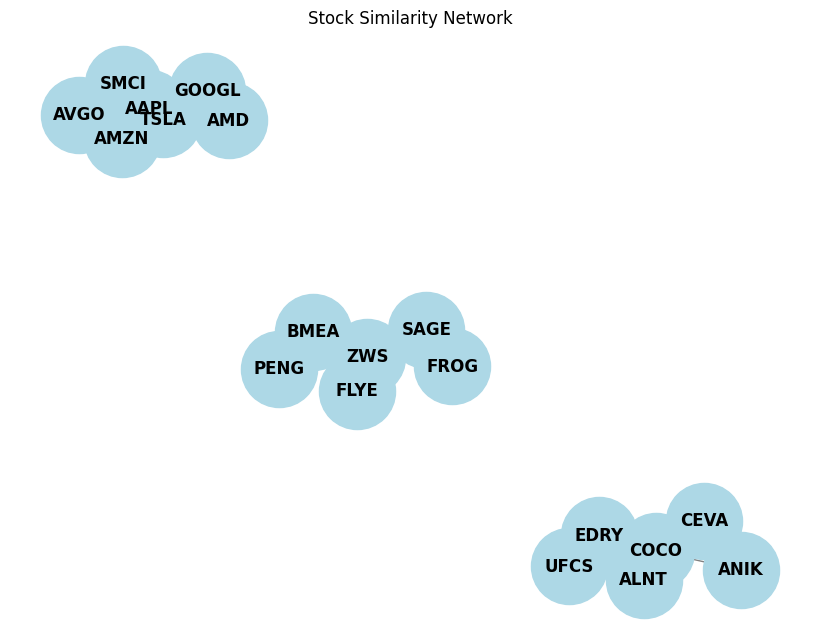

In [198]:
# Creating a graph
G = nx.Graph()

# Adding nodes and edges
for stock, similar_stocks in similar_stock_data.items():
    for similar_stock in similar_stocks:
        G.add_edge(stock, similar_stock)

# Drawing the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)  # Layout the nodes
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=12, font_weight='bold', edge_color='gray')

# Showing the plot
plt.title("Stock Similarity Network")
plt.show()

Before we move onto finding the 5 most similar stocks from different clusters, we want to rank all the stocks based on a new combinational feature.

We combined *AvgPrice*, *Volatility*, and *Volume* into a single ranking score and ranked the stocks below.


In [199]:
def combine_features_and_rank(financial_data, feature_weights=None):
    if feature_weights is None:
        feature_weights = {'AvgPrice': 0.4, 'Volatility': 0.3, 'Volume': 0.3}

    # Calculating the combined score
    financial_data['Score'] = (
        financial_data['AvgPrice'] * feature_weights['AvgPrice'] +
        financial_data['Volatility'] * feature_weights['Volatility'] +
        financial_data['Volume'] * feature_weights['Volume']
    )

    # Sorting by combined score in descending order
    financial_data = financial_data.sort_values(by='Score', ascending=False)

    return financial_data

In [200]:
# Performing clustering and calculate scores
clustered_data = combine_features_and_rank(clustered_data)
clustered_data

,Ticker,AvgPrice,Volatility,Volume,Cluster,Score
4162,SEB,25.272042,17.312321,-0.334574,1,15.202141
1923,FICO,15.699445,23.964248,-0.297094,1,13.379924
566,AZO,26.178270,9.523552,-0.304609,1,13.236991
1871,FCNCA,16.486375,14.825004,-0.313275,1,10.948069
3173,MELI,15.992039,14.588288,-0.249822,1,10.698356
...,...,...,...,...,...,...
2969,LIXTW,-0.372769,-0.366500,-0.334291,0,-0.359345
2600,INAQW,-0.372028,-0.367386,-0.334873,0,-0.359489
3704,PDYNW,-0.372192,-0.367233,-0.335083,0,-0.359571
350,APLMW,-0.372918,-0.367682,-0.335036,0,-0.359983


After ranking the stocks based on their combined score, we created a function that suggests top stocks from different clusters for the user's portfolio diversfication. The function is designed in such a way that the the recommended stocks are from clusters that the user has not already invested in.

In [201]:
def recommend_diversified_stocks(financial_data, input_tickers, scaled_features, kmeans, n_recommendations=5):
    # Identifying the clusters of the user's input stocks
    input_clusters = {}
    for ticker in input_tickers:
        if ticker not in financial_data['Ticker'].values:
            print(f"Ticker {ticker} not found in financial data.")
            continue

        ticker_row = financial_data[financial_data['Ticker'] == ticker]
        ticker_cluster = ticker_row['Cluster'].iloc[0]
        input_clusters[ticker] = ticker_cluster

    # Getting all clusters the user is not invested in
    user_clusters = set(input_clusters.values())

    # Ranking and recommending stocks from clusters that the user does not have
    recommendations = {}
    for cluster in set(financial_data['Cluster']) - user_clusters:
        cluster_stocks = financial_data[financial_data['Cluster'] == cluster]

        # Sorting stocks in the cluster by their Score
        top_stocks = cluster_stocks.head(n_recommendations)
        recommendations[cluster] = top_stocks[['Ticker', 'Score']].head(n_recommendations)['Ticker'].tolist()

    return recommendations

In [202]:
# Getting recommended stocks from different clusters
recommendations = recommend_diversified_stocks(clustered_data, input_tickers, scaled_features_financial_data, kmeans, n_recommendations=5)

print("Diversified portfolio recommendations (from different clusters):\n", recommendations)

Diversified portfolio recommendations (from different clusters):
 {1: ['SEB', 'FICO', 'AZO', 'FCNCA', 'MELI'], 3: ['META', 'MCK', 'GS', 'AMP', 'LMT'], 4: ['GOOG', 'TSM', 'BABA', 'PDD', 'WBA'], 5: ['MKL', 'REGN', 'COKE', 'ASML', 'GWW']}


Visualized below are the top 5 stocks from each cluster that are best suited to diversify the user's portfolio without beig completely different from the already existing stocks.

In [203]:
# Converting the recommended stocks data into a DataFrame
recommendations_formatted = {
    'Cluster': [],
    'Recommended Stock': []
}

for cluster, stocks in recommendations.items():
    for stock in stocks:
        recommendations_formatted['Cluster'].append(cluster)
        recommendations_formatted['Recommended Stock'].append(stock)

# Creating a DataFrame from the structured data
df_recommendations = pd.DataFrame(recommendations_formatted)

# Plotting the Sunburst chart
fig = px.sunburst(df_recommendations, path=['Cluster', 'Recommended Stock'], title="Diversified Portfolio Recommendations")
fig.show()


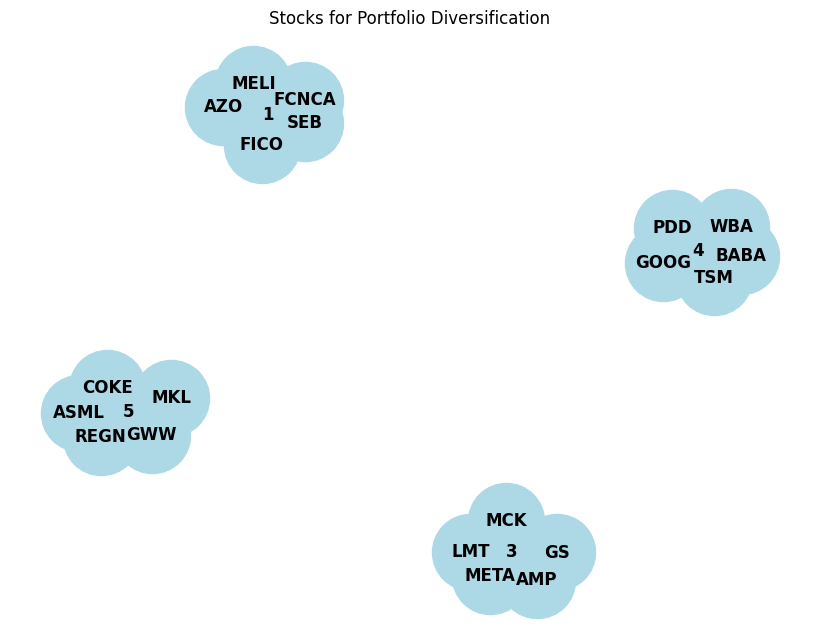

In [204]:
# Creating a graph
G1 = nx.Graph()

# Adding nodes and edges
for stock, diversified_stocks in recommendations.items():
    for diversified_stock in diversified_stocks:
        G1.add_edge(stock, diversified_stock)

# Drawing the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G1, seed=42)  # Layout the nodes
nx.draw(G1, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=12, font_weight='bold', edge_color='gray')

# Showing the plot
plt.title("Stocks for Portfolio Diversification")
plt.show()

# Part 3: Data Preparation for Sentiment Analysis

## Stock Data
We plan to use recent datasets from kaggle having historical market data and also historical stock market news to use it for our models.

Stock data source: https://www.kaggle.com/datasets/jakewright/9000-tickers-of-stock-market-data-full-history

Stock news source: https://www.kaggle.com/datasets/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests/data

In [215]:
import pandas as pd

# Loading stock market data
stock_data = pd.read_csv("/content/drive/My Drive/Stock Dashboard/all_stock_data.csv")

print(stock_data.info())
print(stock_data[::-1].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34646258 entries, 0 to 34646257
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Date          object 
 1   Ticker        object 
 2   Open          float64
 3   High          float64
 4   Low           float64
 5   Close         float64
 6   Volume        float64
 7   Dividends     float64
 8   Stock Splits  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ GB
None
                Date Ticker       Open       High        Low      Close  \
34646257  2024-11-04   SHOO  44.740002  45.150002  44.724998  45.000000   
34646256  2024-11-04    NNN  43.730000  43.439999  43.209999  43.244999   
34646255  2024-11-04   FAMI   0.320000   0.320000   0.300100   0.300100   
34646254  2024-11-04   ENLV   1.400000   1.428900   1.330000   1.350000   
34646253  2024-11-04   NEOG  14.490000  14.580000  14.340000  14.345000   

           Volume  Dividends  Stock Splits  
34646257  26010.0        0.0        

 **Dropping rows which have missing data and filtering the data which are not useful for our model processing late**r

In [216]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')

# Removing rows which are missing critical data
stock_data = stock_data.dropna(subset=['Date', 'Close'])
stock_data = stock_data[stock_data['Ticker'].notnull()]

In [217]:
# Filling missing prices using forward fill using the previous day's data
stock_data[['Open', 'High', 'Low', 'Close']] = stock_data[['Open', 'High', 'Low', 'Close']].fillna(method='ffill')

# Removing rows with extreme prices or low volume
stock_data = stock_data[(stock_data['Close'] < 1e6) & (stock_data['Volume'] > 1)]

<ipython-input-217-40805864af05>:2: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [218]:
stock_data[stock_data['Ticker']=='NVDA'][-5::]

,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits
34610171,2024-10-29,NVDA,140.289993,142.259995,138.899994,141.250000,157593600.0,0.0,0.0
34619982,2024-10-30,NVDA,139.539993,140.330002,136.809998,139.339996,179418100.0,0.0,0.0
34625528,2024-10-31,NVDA,137.600006,137.610001,132.110001,132.759995,270039600.0,0.0,0.0
34637711,2024-11-01,NVDA,134.699997,137.309998,134.570007,135.399994,202737100.0,0.0,0.0
34641761,2024-11-04,NVDA,137.229996,137.750000,135.570007,137.095001,27590992.0,0.0,0.0


In [219]:
# Removing tickers with low average trading volume
min_volume_threshold = 1000
ticker_avg_volume = stock_data.groupby('Ticker')['Volume'].mean()
active_tickers = ticker_avg_volume[ticker_avg_volume > min_volume_threshold].index
stock_data = stock_data[stock_data['Ticker'].isin(active_tickers)]
stock_data.shape

(29798928, 9)

In [220]:
# Filtering 1 year of data to match with the financial news data being used later and also due to resources constraints
start_date = '2019-01-01'
end_date = '2020-10-31'
stock_data = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)]

stock_data.reset_index(drop=True, inplace=True)

# Confirming the date range
print(stock_data['Date'].min(), stock_data['Date'].max())

2019-01-02 00:00:00 2020-10-30 00:00:00


In [222]:
stock_data_backup = stock_data

In [232]:
# Filtering out the tickers which have less than 100 entries
ticker_counts = stock_data['Ticker'].value_counts()
tickers_with_records = ticker_counts[ticker_counts > 100].index
tickers_with_records
stock_data = stock_data[stock_data['Ticker'].isin(tickers_with_records)]
stock_data.shape

(2495948, 9)

In [233]:
stock_data[stock_data['Ticker']=='NVDA'][-5::]

,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits
2493890,2020-10-26,NVDA,13.310588,13.574034,12.925456,13.027315,336896000.0,0.0,0.0
2504558,2020-10-27,NVDA,13.190637,13.325458,13.077129,13.280601,250520000.0,0.0,0.0
2505373,2020-10-28,NVDA,13.083573,13.145036,12.499680,12.517524,376520000.0,0.0,0.0
2511217,2020-10-29,NVDA,12.727190,13.078369,12.639458,12.911082,320080000.0,0.0,0.0
2518291,2020-10-30,NVDA,12.738591,12.824341,12.193360,12.425331,416820000.0,0.0,0.0


### Adding information like moving averages and volatility per ticker to get the performance picture over a period of time

In [234]:
# Computing moving averages and volatility per ticker
stock_data['20D_MA'] = stock_data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
stock_data['50D_MA'] = stock_data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=50, min_periods=1).mean())
stock_data['Daily Returns'] = stock_data.groupby('Ticker')['Close'].transform(lambda x: x.pct_change())
stock_data['Volatility'] = stock_data.groupby('Ticker')['Daily Returns'].transform(lambda x: x.rolling(window=30, min_periods=1).std())

In [235]:
stock_data.shape

(2495948, 13)

In [96]:
stock_data.to_csv("/content/drive/My Drive/Stock Dashboard/filtered_stock_data_2019-20.csv", index=False)

## News data

We need to match the data that we parse with the stock data to combine them together before we train the models. So, we will filter the news_data by dropping irrelevant columns and filtering them to specific dates between 2015 to 2020

In [58]:
import pandas as pd

# Loading the dataset
news_data = pd.read_csv("/content/drive/My Drive/Stock Dashboard/raw_partner_headlines.csv")

# Displaying the structure
print(news_data.head())
print(news_data.columns)
print(news_data.shape)

   Unnamed: 0                                           headline  \
0           2  Agilent Technologies Announces Pricing of $5……...   
1           3  Agilent (A) Gears Up for Q2 Earnings: What's i...   
2           4  J.P. Morgan Asset Management Announces Liquida...   
3           5  Pershing Square Capital Management, L.P. Buys ...   
4           6  Agilent Awards Trilogy Sciences with a Golden ...   

                                                 url  publisher  \
0  http://www.gurufocus.com/news/1153187/agilent-...  GuruFocus   
1  http://www.zacks.com/stock/news/931205/agilent...      Zacks   
2  http://www.gurufocus.com/news/1138923/jp-morga...  GuruFocus   
3  http://www.gurufocus.com/news/1138704/pershing...  GuruFocus   
4  http://www.gurufocus.com/news/1134012/agilent-...  GuruFocus   

                  date stock  
0  2020-06-01 00:00:00     A  
1  2020-05-18 00:00:00     A  
2  2020-05-15 00:00:00     A  
3  2020-05-15 00:00:00     A  
4  2020-05-12 00:00:00     A  
In

In [59]:
# Dropping unnecessary columns
news_data = news_data.drop(columns=['Unnamed: 0', 'url', 'publisher'])

news_data['date'] = pd.to_datetime(news_data['date'], errors='coerce')

# Filtering news by  our date range
start_date = '2019-01-01'
end_date = '2020-12-31'

news_data = news_data[(news_data['date'] >= start_date) & (news_data['date'] <= end_date)]

# Confirming the date range
print(news_data['date'].min(), news_data['date'].max())

# Renaming to ensure coherence between the stock values dafaframe
news_data.rename(columns={'date': 'Date', 'stock': 'Ticker', 'headline': 'Headline'}, inplace=True)
news_data.head()

2019-01-01 00:00:00 2020-06-04 00:00:00


<ipython-input-59-2838bba54497>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_data.rename(columns={'date': 'Date', 'stock': 'Ticker', 'headline': 'Headline'}, inplace=True)


,Headline,Date,Ticker
0,Agilent Technologies Announces Pricing of $5……...,2020-06-01,A
1,Agilent (A) Gears Up for Q2 Earnings: What's i...,2020-05-18,A
2,J.P. Morgan Asset Management Announces Liquida...,2020-05-15,A
3,"Pershing Square Capital Management, L.P. Buys ...",2020-05-15,A
4,Agilent Awards Trilogy Sciences with a Golden ...,2020-05-12,A


## Computing Sentiment Scores

We need a way to convert the textual data into numeric data, so we are using FinBERT, which is a pre-trained LLM model to analyze sentiment of financial text. It is built by further training the BERT language model in the finance domain, using a large financial corpus. More info can be found here: https://huggingface.co/ProsusAI/finbert

We are using this to score the news associated with the tickers so that we don't have to train the sentiment scoring model from scratch

In [60]:
!pip install transformers

In [90]:
news_data.head()

,Headline,Date,Ticker
0,Agilent Technologies Announces Pricing of $5……...,2020-06-01,A
1,Agilent (A) Gears Up for Q2 Earnings: What's i...,2020-05-18,A
2,J.P. Morgan Asset Management Announces Liquida...,2020-05-15,A
3,"Pershing Square Capital Management, L.P. Buys ...",2020-05-15,A
4,Agilent Awards Trilogy Sciences with a Golden ...,2020-05-12,A


In [91]:
stock_data.head()

,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits,20D_MA,50D_MA,Daily Returns,Volatility
0,2017-01-03,MBOT,91.500000,114.750000,90.750000,112.500000,9833.0,0.0,0.0,100.537500,121.359001,0.229508,0.092587
1,2017-01-03,TPR,30.129590,31.046278,30.129590,30.709003,3166300.0,0.0,0.0,31.399863,31.445147,0.013992,0.016301
2,2017-01-03,EDSA,602.700012,611.520020,588.000000,608.580017,382.0,0.0,0.0,607.404004,606.874803,0.019704,0.046370
3,2017-01-03,FHB,29.567902,29.567902,28.838348,29.064762,202000.0,0.0,0.0,28.384688,25.747611,-0.004595,0.016801
4,2017-01-03,ANF,9.963265,10.374121,9.869110,10.365561,4616000.0,0.0,0.0,11.589572,12.333151,0.009167,0.037071


### We are merging the 2 dataframes here so that we do not have to compute sentiment scores on tickers which do not overlap and whose dates do not match


In [80]:
merged_data = pd.merge(news_data, stock_data, on=['Ticker', 'Date'], how='inner')
merged_data.shape

(266819, 14)

In [88]:
merged_data.head()

,Headline,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits,20D_MA,50D_MA,Daily Returns,Volatility,sentiment_score
0,Agilent Technologies Announces Pricing of $5……...,2020-06-01,A,87.082763,89.001673,86.983852,88.932434,2477600.0,0.0,0.0,81.189537,76.344754,0.020082,0.021781,0.036391
1,Agilent (A) Gears Up for Q2 Earnings: What's i...,2020-05-18,A,82.334942,83.472440,81.395275,82.750381,2076000.0,0.0,0.0,76.965471,73.304188,0.025371,0.024165,0.029872
2,J.P. Morgan Asset Management Announces Liquida...,2020-05-15,A,80.623764,81.929412,80.336916,80.702888,4529400.0,0.0,0.0,76.654390,73.199352,-0.000612,0.024559,0.004152
3,"Pershing Square Capital Management, L.P. Buys ...",2020-05-15,A,80.623764,81.929412,80.336916,80.702888,4529400.0,0.0,0.0,76.654390,73.199352,-0.000612,0.024559,0.036012
4,Agilent Awards Trilogy Sciences with a Golden ...,2020-05-12,A,80.692997,81.405170,78.912565,78.981804,2278900.0,0.0,0.0,76.256761,73.221464,-0.017473,0.027134,0.994543


In [93]:
from transformers import pipeline
import torch

print(torch.cuda.is_available())

# Loading FinBERT model
device = 0 if torch.cuda.is_available() else -1
finbert = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone", device=device)

# Function to calculate sentiment scores
def get_finbert_sentiment(text):
    result = finbert(text)[0]
    if result['label'] == 'positive':
        return result['score']
    elif result['label'] == 'negative':
        return -result['score']
    else:
        return 0

# Applying FinBERT to each headline
merged_data['sentiment_score'] = merged_data['Headline'].apply(get_finbert_sentiment)

In [97]:
# Aggregating sentiment scores by Date and Ticker
aggregated_sentiment = (
    merged_data.groupby(['Date', 'Ticker'])['sentiment_score']
    .mean()
    .reset_index()
)

print("Aggregated sentiment scores:")
aggregated_sentiment.head()

Aggregated sentiment scores:


,Date,Ticker,sentiment_score
0,2019-01-02,AAP,0.999186
1,2019-01-02,AB,0.001136
2,2019-01-02,ABEV,0.995713
3,2019-01-02,ACUR,0.948185
4,2019-01-02,ADI,0.001632


In [248]:
# Merging aggregated sentiment scores with the main dataframe merged_data
final_data = pd.merge(
    merged_data,
    aggregated_sentiment,
    on=["Date", "Ticker"],
    how="left",
    suffixes=("", "_agg")
)

# Fill any missing aggregated sentiment scores with 0 or a default value
final_data['sentiment_score'] = final_data['sentiment_score'].fillna(0)

# Check the structure of the final data
final_data.head()

,Headline,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits,20D_MA,50D_MA,Daily Returns,Volatility,sentiment_score
0,Agilent Technologies Announces Pricing of $5……...,2020-06-01,A,87.082763,89.001673,86.983852,88.932434,2477600.0,0.0,0.0,81.189537,76.344754,0.020082,0.021781,0.036391
1,Agilent (A) Gears Up for Q2 Earnings: What's i...,2020-05-18,A,82.334942,83.472440,81.395275,82.750381,2076000.0,0.0,0.0,76.965471,73.304188,0.025371,0.024165,0.029872
2,J.P. Morgan Asset Management Announces Liquida...,2020-05-15,A,80.623764,81.929412,80.336916,80.702888,4529400.0,0.0,0.0,76.654390,73.199352,-0.000612,0.024559,0.004152
3,"Pershing Square Capital Management, L.P. Buys ...",2020-05-15,A,80.623764,81.929412,80.336916,80.702888,4529400.0,0.0,0.0,76.654390,73.199352,-0.000612,0.024559,0.036012
4,Agilent Awards Trilogy Sciences with a Golden ...,2020-05-12,A,80.692997,81.405170,78.912565,78.981804,2278900.0,0.0,0.0,76.256761,73.221464,-0.017473,0.027134,0.994543


In [100]:
final_data.to_csv("/content/drive/My Drive/Stock Dashboard/merged_data_2019-20.csv", index=False)

### Creating new features that will improve model prediction and adding a placeholder for target variable which is the next day's volatility

In [101]:
# Rolling features for sentiment and Close
final_data['sentiment_lag_1'] = final_data.groupby('Ticker')['sentiment_score'].shift(1)
final_data['sentiment_lag_3'] = final_data.groupby('Ticker')['sentiment_score'].rolling(3).mean().reset_index(0, drop=True)
final_data['sentiment_lag_7'] = final_data.groupby('Ticker')['sentiment_score'].rolling(7).mean().reset_index(0, drop=True)
final_data['Close_lag_1'] = final_data.groupby('Ticker')['Close'].shift(1)
final_data['Close_lag_3'] = final_data.groupby('Ticker')['Close'].rolling(3).mean().reset_index(0, drop=True)
final_data['Close_lag_7'] = final_data.groupby('Ticker')['Close'].rolling(7).mean().reset_index(0, drop=True)

In [102]:
# Computing rolling averages for relevant features
final_data['Daily_Returns_rolling_7'] = final_data.groupby('Ticker')['Daily Returns'].rolling(7).mean().reset_index(0, drop=True)
final_data['Volatility_rolling_7'] = final_data.groupby('Ticker')['Volatility'].rolling(7).mean().reset_index(0, drop=True)
final_data['Volume_rolling_7'] = final_data.groupby('Ticker')['Volume'].rolling(7).mean().reset_index(0, drop=True)

final_data['Sentiment_DailyReturns'] = final_data['sentiment_score'] * final_data['Daily Returns']

In [106]:
# Creating target variable for model prediction(Volatility of the next day)
final_data['Volatility_target'] = final_data.groupby('Ticker')['Volatility'].shift(-1)

In [111]:
# Drop rows with NaN values after adding features
final_data = final_data.dropna()
final_data.shape

(249425, 27)

In [112]:
final_data.to_csv("/content/drive/My Drive/Stock Dashboard/merged_data_2019-20_before_norm.csv", index=False)

### Normalizing the numerical columns before model fitting

In [113]:

# Normalize numeric columns (optional)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Daily Returns', 'sentiment_score',
                'sentiment_score_agg', 'Volatility', '20D_MA', '50D_MA']
final_data[numeric_cols] = scaler.fit_transform(final_data[numeric_cols])
final_data.head()

<ipython-input-113-8147d9e4357f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[numeric_cols] = scaler.fit_transform(final_data[numeric_cols])


,Headline,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits,...,sentiment_lag_3,sentiment_lag_7,Close_lag_1,Close_lag_3,Close_lag_7,Daily_Returns_rolling_7,Volatility_rolling_7,Volume_rolling_7,Sentiment_DailyReturns,Volatility_target
6,' Stocks Growing Their Earnings Fast,2020-05-07,A,-0.011678,-0.014454,-0.010752,-0.012483,-0.293168,0.0,0.0,...,0.683749,0.308239,80.386368,79.004885,81.443321,0.007774,0.025696,2.681929e+06,0.008057,0.030499
7,Cypress Asset Management Inc Buys Verizon Comm...,2020-05-07,A,-0.011678,-0.014454,-0.010752,-0.012483,-0.293168,0.0,0.0,...,0.401553,0.324177,77.646484,78.559779,79.831043,0.006061,0.026941,2.498071e+06,0.001197,0.032165
8,Hendley & Co Inc Buys American Electric Power ...,2020-05-05,A,-0.023641,-0.019593,-0.019637,-0.019155,-0.257456,0.0,0.0,...,0.455119,0.351556,77.646484,76.944204,78.800937,0.005904,0.028084,2.412371e+06,0.005378,0.032165
9,Teacher Retirement System Of Texas Buys Hologi...,2020-05-05,A,-0.023641,-0.019593,-0.019637,-0.019155,-0.257456,0.0,0.0,...,0.130708,0.354198,75.539642,76.241923,78.063331,0.009460,0.029171,1.976186e+06,0.000550,0.033412
10,"Cookson Peirce & Co Inc Buys Eli Lilly and Co,...",2020-05-04,A,-0.025593,-0.028286,-0.024260,-0.024825,-0.247536,0.0,0.0,...,0.161716,0.383478,75.539642,74.942866,77.069963,0.010221,0.030436,1.551329e+06,0.001136,0.034011


## Model Training for Volatility Reasoning

In [114]:
# Defining feature columns
features = final_data.drop(['Headline', 'Date', 'Ticker', 'Volatility_target'], axis=1).columns

# Defining the target variable
target = 'Volatility_target'

X = final_data[features]
y = final_data[target]

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (249425, 23)
Target shape: (249425,)


In [115]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (199540, 23)
Test set shape: (49885, 23)


In [142]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Initializing the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, max_depth=6, learning_rate=0.1, random_state=42)

# Training the model
xgb_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = xgb_model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")

Mean Squared Error: 0.0003
R2 Score: 0.6368


An R² score of 0.6398 means the model explains a significant portion (64%) of the variance in the target variable.

RMSE of 0.0185 is small relative to the variability in the target, indicating decent predictive accuracy.


### Visualization of features contributing to the volatility movement

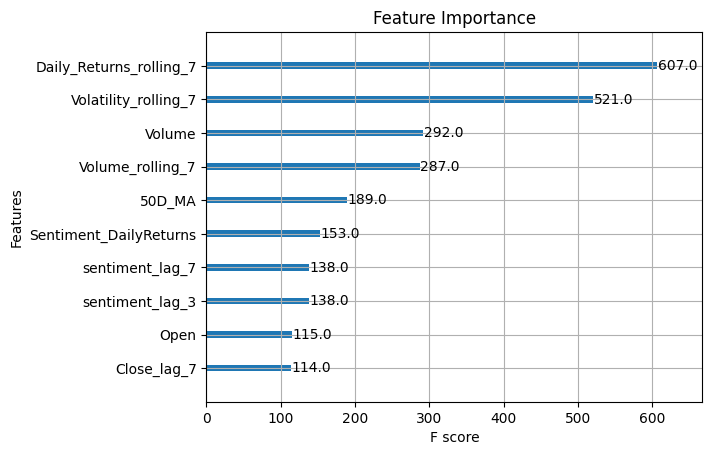

In [143]:
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("Feature Importance")
plt.show()

## Some visualizations of the processed data

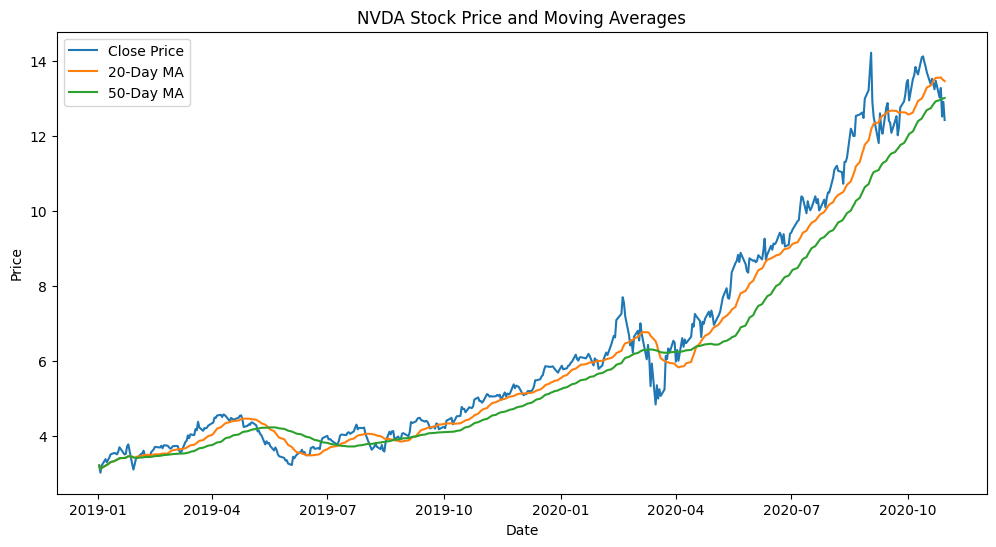

In [274]:
import matplotlib.pyplot as plt

# Example: Plot Close prices for NVDA
selected_ticker = 'NVDA'
stock_data_ticker = stock_data[stock_data['Ticker'] == selected_ticker]

plt.figure(figsize=(12, 6))
plt.plot(stock_data_ticker['Date'], stock_data_ticker['Close'], label='Close Price')
plt.plot(stock_data_ticker['Date'], stock_data_ticker['20D_MA'], label='20-Day MA')
plt.plot(stock_data_ticker['Date'], stock_data_ticker['50D_MA'], label='50-Day MA')
plt.title(f"{selected_ticker} Stock Price and Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [275]:
fig = px.histogram(
    data_frame=stock_data_ticker,
    x='Volatility',
    color='Ticker',
    title='Volatility Distribution',
    nbins=20,
    labels={'Volatility': 'Volatility'},
)
fig.show()



In [277]:
fig = px.density_heatmap(
    data_frame=stock_data_ticker,
    x='Date',
    y='Ticker',
    z='Volume',
    title='Heatmap of Trading Volume',
    labels={'Volume': 'Trading Volume'},
    color_continuous_scale='Viridis',
)
fig.show()
